In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from p24asolver import P24ASolver

In [2]:
MASS_RADIUS = 0.2 #the radius of the mass in the drawing
DRIVER_RADIUS = 0.1 #the radius of the driver in the drawing
ANIMATE_360 = False #true = driver at center of animation; false = driver at bottom of animation
DRAW_TRAIL = True #should the animations draw the trail of the mass as it moves?

In [3]:
class InvPend(P24ASolver):
    """
    Simulate a system of upside down vertical driven pendulum
    """
    
    #  constants used for animating
    
    def __init__(self, **kwargs):
        """
        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__( ( ('theta', '$theta$'), ('thetaD', r'$\dot{theta}_1$') ) )
        # Now store variables, using defaults, if necessary

        # theta (no dot, double dot)
        # angular frequency of the vertical drive
        # A - amplitude of the vertical drive
        # m - the mass of what is being swung
        # l - length of pendulum
        self.theta = kwargs.get('theta', 0)
        self.thetaD = kwargs.get('thetaD', 0)
        self.thetaDD = kwargs.get('thetaDD', 0.0)
        self.A = kwargs.get('A', 1)
        self.m = kwargs.get('m', 5.0)
        self.l = kwargs.get('l', 10.0)
        self.rtol = kwargs.get('rtol', 1e-10)
        self.atol = kwargs.get('atol', 1e-10)
        self.g = kwargs.get('g', 9.81) #note that g here is supposed to be positive!

        self.w = kwargs.get('omega', 100.0)

#    def __str__(self):
#        "Produce a string representation of the parameters"
#        fmt = r"$\mu = {0:.2g}, D = {1:.2g}, \zeta_1 = {2:.2g}, \zeta_2 = {3:.2g}$"
#        return fmt.format(self.μ, self.D, self.ζ1, self.ζ2)

    def derivatives(self, t, list_Values):
        theta, thetaD = list_Values  # unpack the values
        thetaDD = (self.g-self.A*(self.w**2)*np.sin(self.w*t))*np.sin(theta)/(self.l)
        return [thetaD, thetaDD]
    
    def prepare_figure(self): # what gets called before everything in the animation
        # sets up the set of axes and the data series you'll update from frame to frame
        """
        Function that creates the figure and axes for the animation.
        """

        # plt.subplots
          # for animations, we msut have set_xlim and set_ylim, because otherwise the computer
            # tries doing it automatically

        fig, ax = plt.subplots(figsize=(6, 6))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        if ANIMATE_360:
            ax.set_xlim((-(self.l*1.1 + self.A), self.l*1.1 + 2*self.A))
            ax.set_ylim((-(self.l*1.1 + self.A), self.l*1.1 + 2*self.A))
        else:
            ax.set_xlim((-6, 6))
            ax.set_ylim((-1, 11))
            

        # two data series that have no data; 
          # 'k-' = black line
          # there is no data, empty for x and y; when you call plot,
            # it returns two things, but Saeta only wanted to save the
            # first value
            # hence he made two of those things
        self.lines = [ax.plot([], [], 'k-')[0] for n in range(3)]
        # a rectangle that slides back and forth
          # red color
        self.parts = [Circle((3, 10), radius=MASS_RADIUS, color='r')] #the pendulum
        # shows where the drive into the spring is going to be oscillating
          # back and forth - 'g' is green
        self.parts.append(Circle((0, 0), radius=DRIVER_RADIUS, color='g')) #the driver
        # add a patch: the function call to carts makes an object, doesn't
          # associate with axes; doing this forloop makes sure the object
          # is associated with axes in the right way
        for c in self.parts:
            ax.add_patch(c)
            
        return fig, ax

        # lay ground work
        # prepare figure
        # place figure in the frame
          # figures will be stored in class object
        # bare minimum; subplots
        # at least one data series to update for each frame
          # make them a list; return the figure and the axes


    def plot_thetaDot(self):
      " a function that plots theta dot over time "
      # takes thetaDot and increases time
      # uses methods similar to the springs, but graphs it

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        # evaluate solution at time t
          # we might only need one x, y, and v - the old code
          # had two x and two v because there were two masses
        theta, thetaD = self.solution.sol(t)
        x_d = 0
        y_d = self.A*np.sin(self.w*t)
        x_m = x_d + self.l*np.sin(theta)
        y_m = y_d + self.l*np.cos(theta)
#         x1 += 2.5
#         x2 += 7.5
#         x3 = 12 + self.D * np.sin(t * self.ω)

        # With lines things are easy: just replace the data
          # replaces data from existing theory
        #make a line between the two relevant points, without overlapping the circles for mass or driver
        self.lines[0].set_data((x_d + DRIVER_RADIUS*np.sin(theta), x_m - MASS_RADIUS*np.sin(theta)),
                               (y_d + DRIVER_RADIUS*np.cos(theta), y_m - MASS_RADIUS*np.cos(theta)))
        
        # For patches, we first remove them
        # and then recreate them.
        self.parts[1].remove()
        self.parts[0].remove()
        self.parts = []
        
        # need to remove elements one at a time or they don't get removed from the plot
        p = Circle((x_m, y_m), radius=0.2, color='r')
        self._ax.add_patch(p)
        self.parts.append(p)
        
        c = Circle((x_d, y_d), radius=0.1, color='g')
        self.parts.append(c)
        self._ax.add_patch(c)
        
        if DRAW_TRAIL:
            trail = Circle((x_m, y_m), radius=0.05, color='k')
            self._ax.add_patch(trail)
        
        title = self._ax.set_title(f"t = {t:.2f}", usetex=False)
        
        return self.parts, self.lines, title

<IPython.core.display.Javascript object>


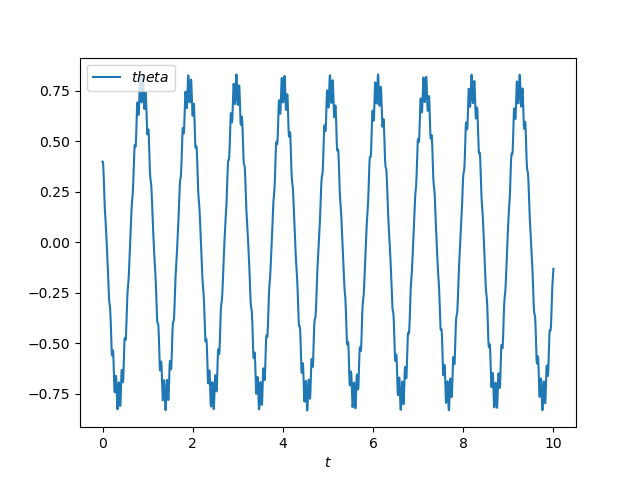

In [5]:
#FIRST TEST: Kapitza's Pendulum 1

# variables for this test:
theta_0, thetaD_0 = 0.4, 0
tRange = (0, 10) # a tuple in the form (t_0, t_f)

# variables for plotting:
drawPlot = True
numPlottedFrames = 2001


#running the simulation:
Y0 = (theta_0, thetaD_0)
Kpend1 = InvPend(theta=theta_0)
Kpend1 = Kpend1.solve(Y0, tRange)

#making the plot:
if drawPlot:
    times = np.linspace(*tRange, numPlottedFrames)
    Kpend1 = Kpend1.plot(times, ["theta"])

<IPython.core.display.Javascript object>


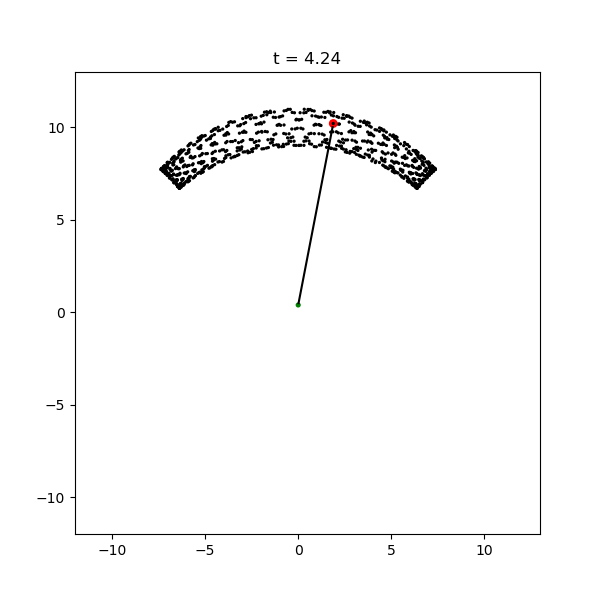

In [6]:
# ANIMATES OUR FIRST TEST
ANIMATE_360 = True
DRAW_TRAIL = True
anim = Kpend1.animate(2000);

In [ ]:
plt.close('all')

Now, let's try non-driven pendulum to make sure everything is working as it should be.

In [ ]:
#SECOND TEST: Regular Pendulum

# variables for this test:
theta_0, thetaD_0 = np.pi-0.4, 0
tRange = (0, 20)
w, A = 0, 0

# variables for plotting
drawPlot = True
numPlottedFrames = 2001


#running the simulation:
Y0 = (theta_0, thetaD_0)
RegPend = InvPend(theta=theta_0, omega=w, A=A)
RegPend = RegPend.solve(Y0, tRange)

#making the plot:
if drawPlot:
    times = np.linspace(*tRange, numPlottedFrames)
    RegPend = RegPend.plot(times, ["theta"])

In [ ]:
# ANIMATES OUR REGULAR PENDULUM TEST
ANIMATE_360 = True
DRAW_TRAIL = True
anim = RegPend.animate(200);

What happens if we drive it in the right-side-up pendulum swing?

**would want to experimentally find the angular frequency of the pendulum

In [ ]:
#THIRD TEST: Driven Regular Pendulum

# variables for this test:
theta_0, thetaD_0 = np.pi-0.4, 0
tRange = (0, 20)
w, A = 50, 0.5

# variables for plotting
drawPlot = True
numPlottedFrames = 2001


#running the simulation with the above choices of starting variable
Y0 = (theta_0, thetaD_0)
DrivenRegularPendulum = InvPend(theta=theta_0, omega=w, A=A)
DrivenRegularPendulum.solve(Y0, tRange)

#making the plot
if drawPlot:
    times = np.linspace(*tRange, numPlottedFrames)
    DrivenRegularPendulum.plot(times, ["theta"])

notice the higher frequency! this is because the driving of the motor propels the mass toward equilibrium.

In [4]:
# ANIMATES OUR DRIVEN PENDULUM TEST
ANIMATE_360 = True
DRAW_TRAIL = True
anim = DrivenRegularPendulum.animate(2000);

NameError: name 'DrivenRegularPendulum' is not defined

In [ ]:
#FOURTH TEST: Driven Regular Pendulum

# variables for this test:
theta_0, thetaD_0 = np.pi-0.4, 0
tRange = (0, 20)
w, A = 50, 0.5

# variables for plotting
drawPlot = True
numPlottedFrames = 2001


#running the simulation with the above choices of starting variable
Y0 = (theta_0, thetaD_0)
DrivenRegularPendulum = InvPend(theta=theta_0, omega=w, A=A)
DrivenRegularPendulum.solve(Y0, tRange)

#making the plot
if drawPlot:
    times = np.linspace(*tRange, numPlottedFrames)
    DrivenRegularPendulum.plot(times, ["theta"])

notice the higher frequency! this is because the driving of the motor propels the mass toward equilibrium.

In [ ]:
# ANIMATES OUR DRIVEN PENDULUM TEST
ANIMATE_360 = True
DRAW_TRAIL = True
anim = DrivenRegularPendulum.animate(2000);

In [ ]:
def find_amplitude_and_phase(**kwargs):
    t_max = 49.750
    sol = Carts(**kwargs)
    sol.solve((0,0,0,0), (0, t_max))
    # Now we need to extract the amplitude and phase for x1 and x2
    # We can do that by restarting the solution using the end point as the initial condition
    Y0 = sol(t_max)
    period = 2 * np.pi / sol.ω
    t_range = (t_max, t_max + 1.5 * period)
    sol2 = Carts(**kwargs)
    sol2.events = [lambda t, Y, args: Y[0], lambda t, Y, args: Y[2]]
    sol2.solve(Y0, t_range)
    t0 = period * np.floor(t_max / period)
    try:
        t1 = sol2.solution.t_events[0][0]
    except:
        print(sol2.solution)
    def adjust_phase(ϕ):
        two_pi = 2 * np.pi
        while ϕ > 0: ϕ -= two_pi
        while ϕ < -two_pi: ϕ += two_pi
        return ϕ
            
    ϕ1 = (t0 - t1) * sol2.ω + (0 if sol2.solution.y_events[0][0,1] > 0 else np.pi)
    A1 = np.abs(sol2(t1 + 0.25 * period)[0])
    t2 = sol2.solution.t_events[1][0]
    ϕ2 = (t0 - t2) * sol2.ω + (0 if sol2.solution.y_events[1][0,3] > 0 else np.pi)
    A2 = np.abs(sol2(t2 + 0.25 * period)[2])
    return (A1, adjust_phase(ϕ1), A2, adjust_phase(ϕ2))

In [ ]:
find_amplitude_and_phase(Omega=1.4)

In [ ]:
Omegas = 10**np.linspace(-1,1,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
amps, phases = axes
amps.loglog(Omegas, results[:,0], label=r'$|A_1|$')
amps.loglog(Omegas, results[:,2], label=r'$|A_2|$')
amps.set_xlabel(r"$\omega/\omega_0$")
amps.legend()
amps.grid()
phases.semilogx(Omegas, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.semilogx(Omegas, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360, 0, 5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Very interesting! We see two resonance peaks in the motion of the two carts: one at $\Omega = \omega/\omega_0 = 1$ and one at $\Omega \approx 1.7$. Let's zoom in a make a close-up plot of this interesting region.

In [ ]:
Omegas2 = np.linspace(0.8,2,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas2])
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)
amps, phases = axes
amps.semilogy(Omegas2, results[:,0], label=r'$|A_1|$')
amps.semilogy(Omegas2, results[:,2], label=r'$|A_2|$')
amps.legend()
phases.plot(Omegas2, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.plot(Omegas2, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360,0,5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Can you explain this behavior?

Other things to explore:
- Can you calculate an analytic solution and compare it with the numerical results?
- Does it matter which cart has the damper?
- What does the phase plot tell us?
- How does the mass ratio influence the plots?
- ...

# Animation

Let’s see if we can't animate the motion of the carts. We will need to figure out how to show the two carts and drive. If we’re hard core, we may also figure out how to draw the springs. Rather than replacing the old class, I'll just define a new one here. Not sure why!

In [ ]:
csol = Carts(mu=1, Omega=2)
csol.solve((0,0,0,0), (0, 10))
tvals = np.linspace(0, 10, 400)
csol.plot(tvals, ['x1', 'x2']);

In [ ]:
csol.animate(300, time_range=(0,10));

In [ ]:
csol2 = Carts(mu=1, Omega=1.41).solve((0,0,0,0),(0, 10)).plot(np.linspace(0, 10, 400), ['x1', 'x2']);

In [ ]:
plt.close('all')
csol2.animate(300, time_range=(0, 10));